# Home Credit Default Risk - Modelling

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
from function import reduce_memory_usage_pl

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
import xgboost as xgb
import catboost as cb
import shap
import optuna
import joblib

In [3]:
train = pl.read_csv('../data/trains.csv')
test = pl.read_csv('../data/test.csv')

In [4]:
train = reduce_memory_usage_pl(train, 'train')
test = reduce_memory_usage_pl(test, 'test')

Memory usage of dataframe train is 275.56 MB
Memory usage of dataframe train became 83.58 MB
Memory usage of dataframe test is 43.27 MB
Memory usage of dataframe test became 13.2 MB


## Bare Modelling

Here we will do modelling on the entire dataset and see what the initial performances would be.

In [ ]:
train = train.to_pandas()
test = test.to_pandas()

In [7]:
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']

In [8]:
numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32', 'int16', 'float16', 'int8']).columns.to_list()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.to_list()

In [9]:
numeric_transformer = make_pipeline(StandardScaler())

In [10]:
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))

In [11]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features))

Above is our data preprocessing pipeline, which includes standardizing numerical features and doing one hot encoding on categorial features.

### XGBoost

In [12]:
class_counts = np.bincount(y)
imbalance_ratio = class_counts[0] / class_counts[1] 

clf = make_pipeline(preprocessor, xgb.XGBClassifier(
    tree_method='gpu_hist',
    scale_pos_weight=imbalance_ratio
)).set_output(transform="pandas")

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'FLAG_MOBIL',
                                                   'FLAG_EMP_P...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [15]:
y_pred = clf.predict(X_test)

In [16]:
y_pred_proba = clf.predict_proba(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     56460
           1       0.18      0.62      0.28      5043

    accuracy                           0.73     61503
   macro avg       0.57      0.68      0.56     61503
weighted avg       0.89      0.73      0.79     61503



In [18]:
print(recall_score(y_test, y_pred))

0.6224469561768788


In [19]:
print(roc_auc_score(y_test, y_pred))

0.6825837331362609


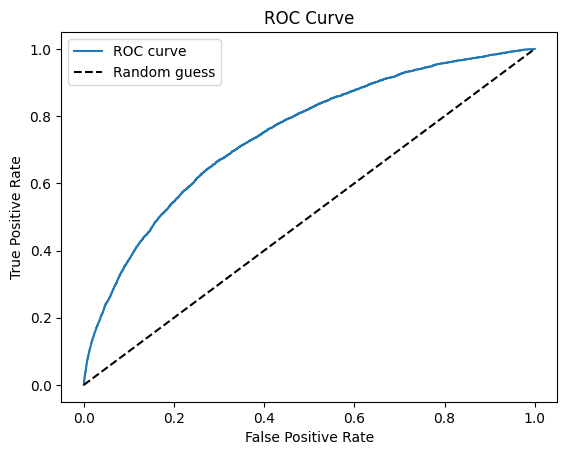

In [20]:
curve = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(curve[0], curve[1], label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

From the above XGBoost model we have got reasonable socres for roc auc and recall but they can be further improved.

### CatBoost

In [21]:
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

clf_cat = make_pipeline(preprocessor, cb.CatBoostClassifier(
    task_type='GPU',
    class_weights=class_weights,
    verbose=False
)).set_output(transform="pandas")

In [22]:
clf_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'FLAG_MOBIL',
                                                   'FLAG_EMP_P...
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001D8DF43B730>)])

In [23]:
y_pred = clf_cat.predict(X_test)

In [24]:
y_pred_proba = clf_cat.predict_proba(X_test)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56460
           1       0.17      0.68      0.28      5043

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.77     61503



In [26]:
print(recall_score(y_test, y_pred))

0.677771167955582


In [27]:
print(roc_auc_score(y_test, y_pred))

0.6953857610943337


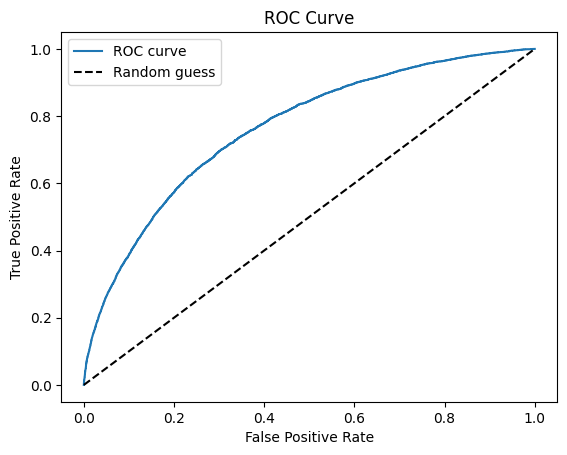

In [28]:
curve = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(curve[0], curve[1], label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The CatBoost model has given as a slightly better performance as compared to the XGBoost model bu still there is a room for improvement here as well.

## Dimensionality Reduction

Now let us try to reduce the dimensionality of the data.

In [29]:
batches = 100
iPca = IncrementalPCA(n_components=218, whiten=True)

X_train_preprocessed = preprocessor.transform(X_train)

for batch in np.array_split(X_train_preprocessed, batches):
    iPca.partial_fit(batch)

X_reduced = iPca.transform(X_train_preprocessed)

First we run the PCA for the entire features taken as components.

In [30]:
cumulative_variance_ratio = np.cumsum(iPca.explained_variance_ratio_)

Then we will take the features cumulative variance ratio

In [31]:
desired_threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= desired_threshold) + 1
print(f"Number of components required to explain {desired_threshold*100}% of the variance: {n_components}")

Number of components required to explain 99.0% of the variance: 96


After settign our desired threshold that might represent the desired amount of variance we got a number of components value of 96

In [32]:
batches = 100
iPca = IncrementalPCA(n_components=n_components, whiten=True)

X_train_preprocessed = preprocessor.transform(X_train)

for batch in np.array_split(X_train_preprocessed, batches):
    iPca.partial_fit(batch)

X_reduced = iPca.transform(X_train_preprocessed)

Then we run PCA again with those components

In [33]:
loading_vectors = iPca.components_
loading_vectors = loading_vectors.T
selected_features_indices = np.argmax(np.abs(loading_vectors), axis=1)

n = n_components
selected_features = []
for i in selected_features_indices[:n]:
    selected_features.append(X_train_preprocessed.columns[i])

print(f"Number of selected features: {len(selected_features)}")

X_train_selected = X_train_preprocessed[selected_features]

Number of selected features: 96


After that it looks like all of the compnents have been selected and we haven't managed to reduce the dimensionality significantly.

In [34]:
X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

Anyhow I have decided to do some model training on the reduced data.

In [35]:
clf2 = xgb.XGBClassifier(
    tree_method='gpu_hist',
    scale_pos_weight=imbalance_ratio
)

In [36]:
duplicates = X_selected_train.columns[X_selected_train.columns.duplicated()].unique()
duplicates = duplicates.to_list()

X_selected_train = X_selected_train.drop(duplicates, axis=1)

In [37]:
clf2.fit(X_selected_train, y_selected_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
X_selected_test = X_selected_test.drop(duplicates, axis=1)

In [39]:
y_pred = clf2.predict(X_selected_test)

In [40]:
y_pred_proba = clf2.predict_proba(X_selected_test)

In [41]:
print(classification_report(y_selected_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     45243
           1       0.15      0.60      0.24      3959

    accuracy                           0.69     49202
   macro avg       0.55      0.65      0.52     49202
weighted avg       0.89      0.69      0.76     49202



In [42]:
recall_score(y_selected_test, y_pred)

0.5953523617075019

In [43]:
roc_auc_score(y_selected_test, y_pred)

0.6490344020150356

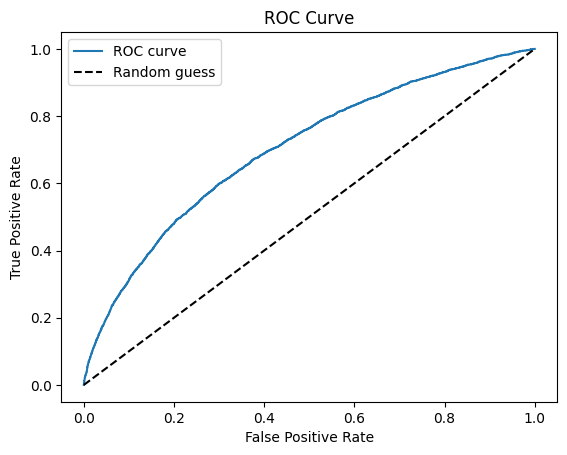

In [44]:
curve = roc_curve(y_selected_test, y_pred_proba[:,1])

plt.plot(curve[0], curve[1], label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

From the performances of the above model we can see that it didn't perform well as compared to the previous models we had.

## Feature Selection

In [45]:
X_train_shap = preprocessor.fit_transform(X_train)

In [46]:
X_test_shap = preprocessor.transform(X_test)

In [47]:
# take 20% of the data and run shap tree explainer
X_train_shap_sample = X_train_shap.sample(frac=0.2, random_state=42)

explainer = shap.TreeExplainer(clf_cat[1])
shap_values = explainer.shap_values(X_train_shap_sample)

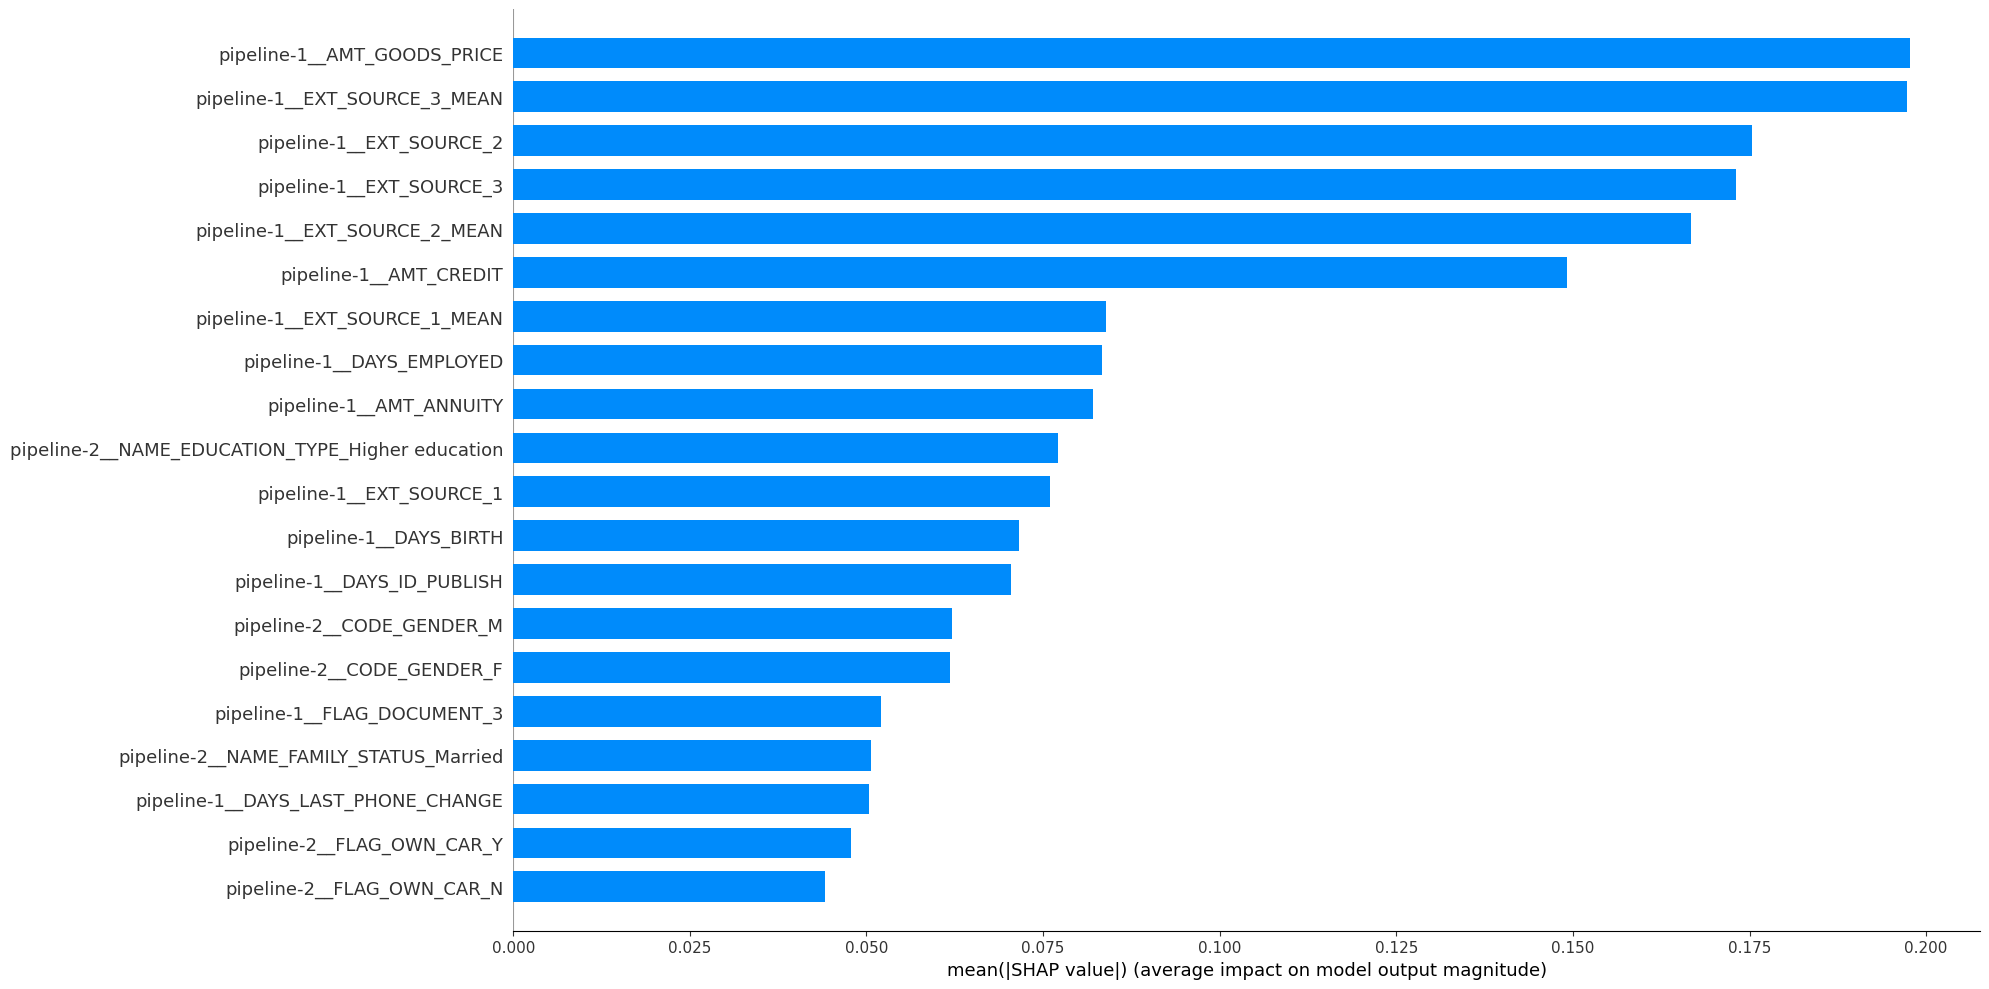

In [48]:
shap.summary_plot(shap_values, X_train_shap_sample, plot_type="bar", plot_size=(20, 10))

Using shap we can see which features had the most impact on our most performant model - the catboost model

Looking above the AMT_GOODS_PRICE and EXT_SOURCE_3_MEAN actually had the highest impact.

In [49]:
shap_df = pd.DataFrame(shap_values, columns=X_train_shap_sample.columns)

In [50]:
filtered_shap_df = shap_df.loc[:, shap_df.abs().mean() >= 0.05]

I have decided to take the features above 0.05 SHAP value

In [51]:
selected_features = filtered_shap_df.columns.tolist()

In [52]:
X_new = preprocessor.fit_transform(X)

In [53]:
X_reduced = X_new[selected_features]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [64]:
joblib.dump(X_test, '../data/x_test.joblib')

['../data/x_test.joblib']

In [55]:
clf_cat_reduced = cb.CatBoostClassifier(
    task_type='GPU',
    class_weights=class_weights,
    verbose=False
)

In [56]:
clf_cat_reduced.fit(X_train, y_train)

In [57]:
y_pred = clf_cat_reduced.predict(X_test)

In [58]:
y_pred_proba = clf_cat_reduced.predict_proba(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     56460
           1       0.17      0.67      0.27      5043

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



In [60]:
print(recall_score(y_test, y_pred))

0.6749950426333532


In [61]:
print(roc_auc_score(y_test, y_pred))

0.690295962691101


After doing the modelling I have got a little increase in the metrics used.

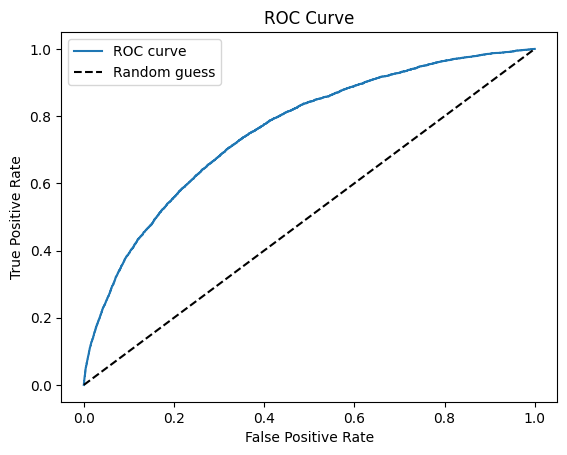

In [62]:
curve = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(curve[0], curve[1], label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [59]:
joblib.dump(clf_cat_reduced, '../models/catboost_reduced.joblib')

['../models/catboost_reduced.joblib']

## Hyperparameter Tuning

Then I moved on to do hyperparameter tuning on the CatBoost model.

In [46]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train.sample(frac=0.2, random_state=42), y_train.sample(frac=0.2, random_state=42), test_size=0.2, random_state=42)

1. `iterations`: This hyperparameter determines the number of boosting iterations or trees in the CatBoost model. It controls the complexity and learning capacity of the model.

2. `learning_rate`: It represents the step size at each iteration when adjusting the model's weights. A smaller learning rate makes the learning process more stable but may require more iterations.

3. `depth`: This hyperparameter sets the maximum depth of the decision trees in the ensemble. Deeper trees can capture more complex relationships but can lead to overfitting if not controlled.

4. `l2_leaf_reg`: It controls the L2 regularization strength for the leaf values in the trees. Higher values penalize large leaf values, helping to prevent overfitting.

5. `border_count`: This hyperparameter determines the number of splits for categorical features in the dataset. It influences how categorical variables are treated during tree construction.

For the objective function I am using roc auc score for the scoring mechanism

In [47]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.001, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'class_weights': class_weights,
        'task_type': 'GPU',
        'verbose': False
    }

    clf = cb.CatBoostClassifier(**params)

    clf.fit(X_val_train, y_val_train)

    y_pred = clf.predict(X_val_test)

    return roc_auc_score(y_val_test, y_pred)

In [48]:
import joblib

In [49]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_roc_auc = study.best_value
print("Best Hyperparameters:", best_params)
print("Best ROC AUC:", best_roc_auc)

joblib.dump(study, 'cat_study.pkl')

Best Hyperparameters: {'iterations': 786, 'learning_rate': 0.073317747882157, 'depth': 1, 'l2_leaf_reg': 0.001683799632074892, 'border_count': 109}
Best ROC AUC: 0.6772156371065083


['cat_study.pkl']

After ruuning the optuna study I have got the above hyperparameters.

Now let's move on to modelling

In [50]:
clf_optuna = cb.CatBoostClassifier(
    **best_params,
    class_weights=class_weights,
    task_type='GPU',
    verbose=False
)

In [ ]:
clf_optuna.fit(X_train, y_train)

In [53]:
y_pred = clf_optuna.predict(X_test)

In [54]:
y_pred_proba = clf_optuna.predict_proba(X_test)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56460
           1       0.55      0.01      0.02      5043

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [56]:
print(roc_auc_score(y_test, y_pred))

0.5056954874582312


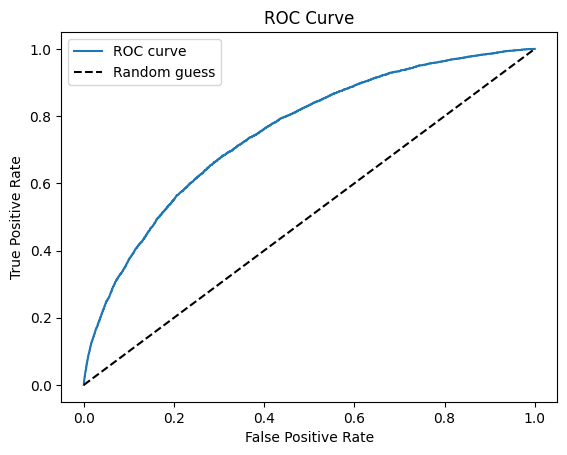

In [103]:
curve = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(curve[0], curve[1], label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

After the end of modelling I found that the performance of the model hasn't improved so I will be moving on with the previos model.

## Multi Output Model

As an additional task I have tried to create a multi output regression model, to predict the AMT_CREDIT and AMT_INCOME_TOTAL columns.

In [63]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = train.drop(['TARGET', 'AMT_CREDIT', 'AMT_INCOME_TOTAL'], axis=1)
y = train[['AMT_CREDIT', 'AMT_INCOME_TOTAL']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32', 'int16', 'float16', 'int8']).columns.to_list()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.to_list()

numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features))

In [64]:
y.describe()

,AMT_CREDIT,AMT_INCOME_TOTAL
count,3.075110e+05,3.075110e+05
mean,5.990260e+05,1.687979e+05
std,4.024908e+05,2.371231e+05
min,4.500000e+04,2.565000e+04
25%,2.700000e+05,1.125000e+05
50%,5.135310e+05,1.471500e+05
75%,8.086500e+05,2.025000e+05
max,4.050000e+06,1.170000e+08


In [65]:
clf_xgb = make_pipeline(preprocessor, MultiOutputRegressor(xgb.XGBRegressor(
    tree_method='gpu_hist',
))).set_output(transform="pandas")

clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)

In [66]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred, multioutput='raw_values'))

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred, multioutput='raw_values'))

Mean Squared Error: [1.9142252e+09 1.9760062e+10]
Mean Absolute Error: [28566.426 50115.49 ]


The above scores tell us the model is doing good for the AMT_CREDIT column but not as good for the AMT_INCOME_TOTAL column

## Conclusion

Above I have tried modelling using gradient boosted tree models like XGBoost and CatBoost. The best performance model had a roc auc score of `0.69` and a recall score of `0.67`. When I looked at the original competition on Kaggle for this same dataset. The best model had a roc score of `0.80570`. So, I think my model hasn't performed really bad.

There are many rooms for improvement in this project starting from the EDA and Data Preprocessing part up to modelling.